In [3]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
from pathlib import Path

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from networks import *
import h5py
from tenpy.tools import hdf5_io

In [13]:
L = 4
L2 = 2
N = 4
m = 5.0
U = 8.0
pbc = True
query_dict_dmrg =  {"L": L, "L2": L2, "N": N, "t": 1.0, "U": U, "m": m, "pbc": pbc}
date_dmrg = "20250106_06"#"20241217_07"
date_netket = "20250108_17"#"20241224_09"

BASE_PATH_DMRG = Path(f"/home1/wttai/machine_learning/dmrg_qwz/")
database_path_dmrg = BASE_PATH_DMRG / f"data/dmrg_qwz_{date_dmrg}/database.json"

data_dmrg = []

with open(database_path_dmrg, "r") as f:
    database = json.load(f)
    for entry in database:
        metadata = entry["metadata"]
        matched = True
        for key, value in query_dict_dmrg.items():
            if metadata[key] != value:
                matched = False
                break
        if matched:
            filename = entry["outputFilename"]
            print(filename)
            path = BASE_PATH_DMRG / filename 
            with h5py.File(path, 'r') as f:
                data = hdf5_io.load_from_hdf5(f)
                data_dmrg.append(data)

data/dmrg_qwz_20250106_06/L=4_L2=2_N=4_t=1.0_m=5.0_U=8.0_pbc_real/dmrg_log_chi_max=1000.h5


data/netket_qwz_20250108_17/L=4_L2=2_N=4_t=1.0_m=5.0_U=8.0_pbc_real/nj_log_n_hidden=128_n_hidden_layers=2_exact_sampling_run=1.json
data/netket_qwz_20250108_17/L=4_L2=2_N=4_t=1.0_m=5.0_U=8.0_pbc_real/nj_log_n_hidden=128_n_hidden_layers=4_exact_sampling_run=1.json
data/netket_qwz_20250108_17/L=4_L2=2_N=4_t=1.0_m=5.0_U=8.0_pbc_real/nj_log_n_hidden=128_n_hidden_layers=1_exact_sampling_run=1.json
data/netket_qwz_20250108_17/L=4_L2=2_N=4_t=1.0_m=5.0_U=8.0_pbc_real/nj_log_n_hidden=128_n_hidden_layers=3_exact_sampling_run=1.json
data/netket_qwz_20250108_17/L=4_L2=2_N=4_t=1.0_m=5.0_U=8.0_pbc_real/nj_log_n_hidden=128_n_hidden_layers=5_exact_sampling_run=1.json


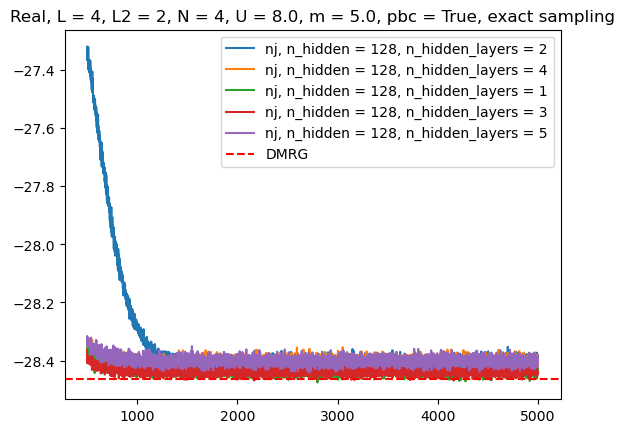

In [14]:
n_samples = 8192
query_dict = {"L": L, "N": N, "t": 1.0, "U": U, "m": m, "pbc": pbc, "n_samples": n_samples, 'complex': False, 'exact_sampling': True, 'n_hidden': 128, 'model': 'nj'}   
#date_netket = "20241128_2048"
BASE_PATH = Path(f"/home1/wttai/machine_learning/netket_qwz/")
database_path = BASE_PATH / f"data/netket_qwz_{date_netket}/database.json"

data_to_plot = []

with open(database_path, "r") as f:
    database = json.load(f)
    for entry in database:
        metadata = entry["metadata"]
        matched = True
        for key, value in query_dict.items():
            if metadata[key] != value:
                matched = False
                break
        if matched:
            filename = entry["outputFilename"]+ ".json"
            print(filename)
            path = BASE_PATH / filename 
            data = json.load(open(path))
            data_to_plot.append(data)


start = 500
end = -1
for data in data_to_plot:
    plt.plot(data['data']["Energy"]["iters"][start:end], data['data']["Energy"]['Mean']['real'][start:end], label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")

plt.axhline(y=data_dmrg[0]['data']['E0'], color='r', linestyle='--', label='DMRG') 
title = f"Real, L = {L}, L2 = {L2}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, exact sampling"
plt.title(title)
plt.legend()

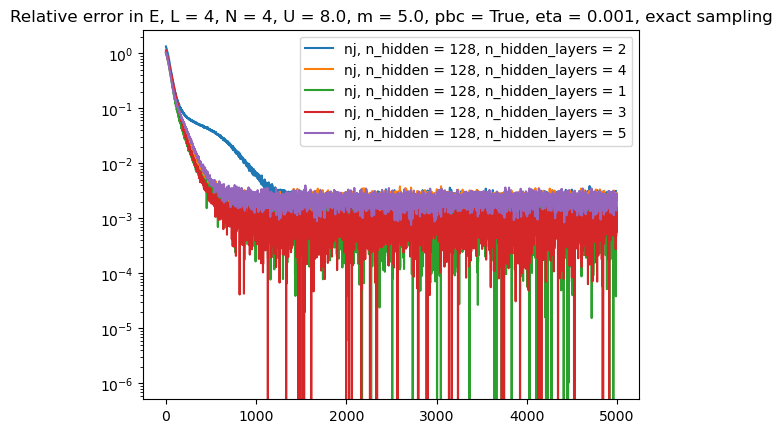

In [15]:
learning_rate = data_to_plot[0]['metadata']['learning_rate']

dmrg_E0 = data_dmrg[0]['data']['E0']
for data in data_to_plot:
    plt.semilogy(data['data']["Energy"]["iters"], -(data['data']["Energy"]['Mean']['real']-dmrg_E0)/dmrg_E0, label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")

title = f"Relative error in E, L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, eta = {learning_rate}, exact sampling"
plt.title(title)
plt.legend()

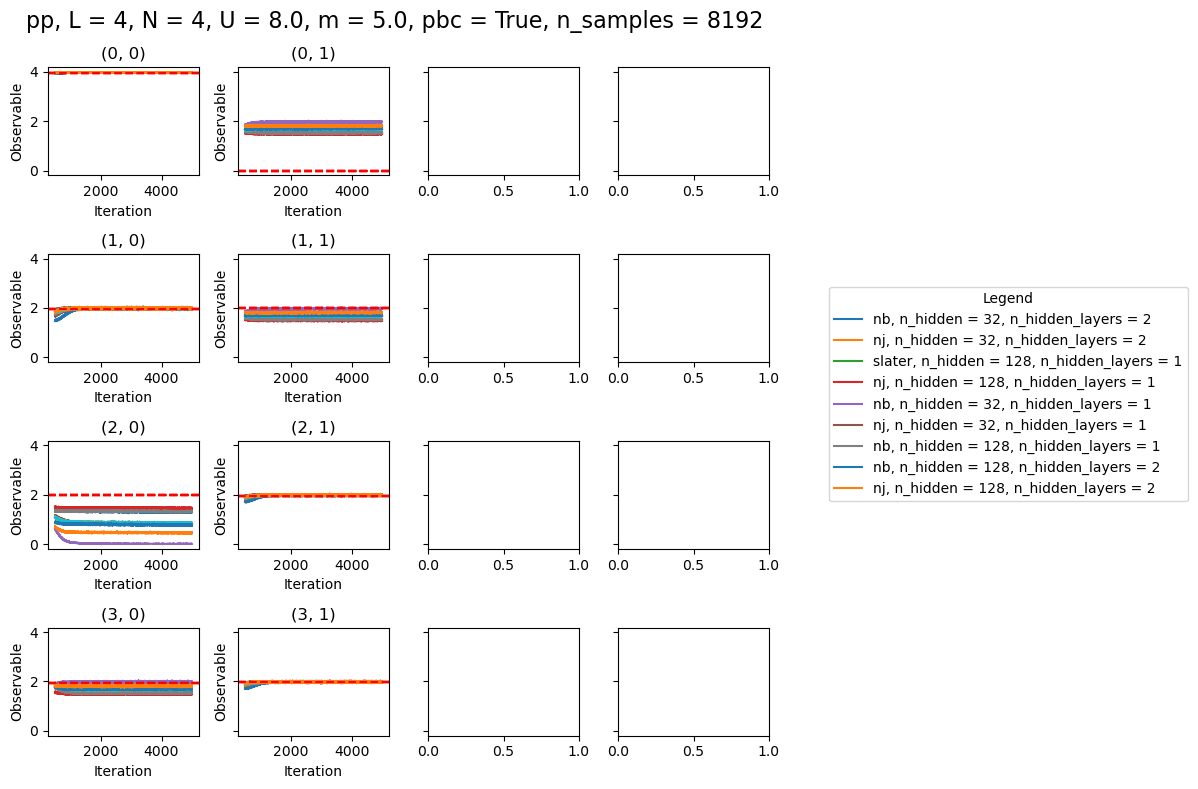

In [21]:
n_corrs = L * L2

x_values = np.arange(len(data["data"]['ss'][0]['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

lines = []
labels = []


# I accidentally scrambled the dmrg orbitals in the database, so I have to manually specify the correct combinations
combinations =[['ss', 'ss'], ['sp', 'sp'], ['pp', 'pp']]  #[['ss', 'ss'], ['sp', 'pp'], ['pp', 'sp']] 

orbitals_nk, orbitals_dmrg = combinations[2]

for data in data_to_plot:
    for i in range(n_corrs):
        x = i // L2
        y = i % L2
        #corr = f"nc{i}nc0"
        line, = axs[x][y].plot(x_values[start:end], 
                               data["data"][orbitals_nk][i]['Mean']['real'][start:end], 
                               label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")

        corrs_dmrg = (data_dmrg[0]['data']['corrs_results'][orbitals_dmrg])
        # corrs_dmrg = (data_dmrg[0]['data']['corrs_results']['dd']
        #             + data_dmrg[0]['data']['corrs_results']['uu'] 
        #             + 2 * data_dmrg[0]['data']['corrs_results']['ud'])/16
        axs[x][y].axhline(y=corrs_dmrg[x][y], color='r', linestyle='--', label='DMRG') 
        
        axs[x][y].set_title(f"({x}, {y})")
        axs[x][y].set_xlabel('Iteration')
        axs[x][y].set_ylabel('Observable')

        # Collect lines and labels for the legend
        if line.get_label() not in labels:
            lines.append(line)
            labels.append(line.get_label())

title = f"{orbitals_nk}, L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, n_samples = {n_samples}"
fig.suptitle(title, fontsize=16)

# Add a shared legend to the right of the figure
fig.legend(
    lines, labels, 
    loc='center right', 
    title="Legend", 
    bbox_to_anchor=(1.5, 0.5)
)


# Show the plot
plt.tight_layout()
plt.show()


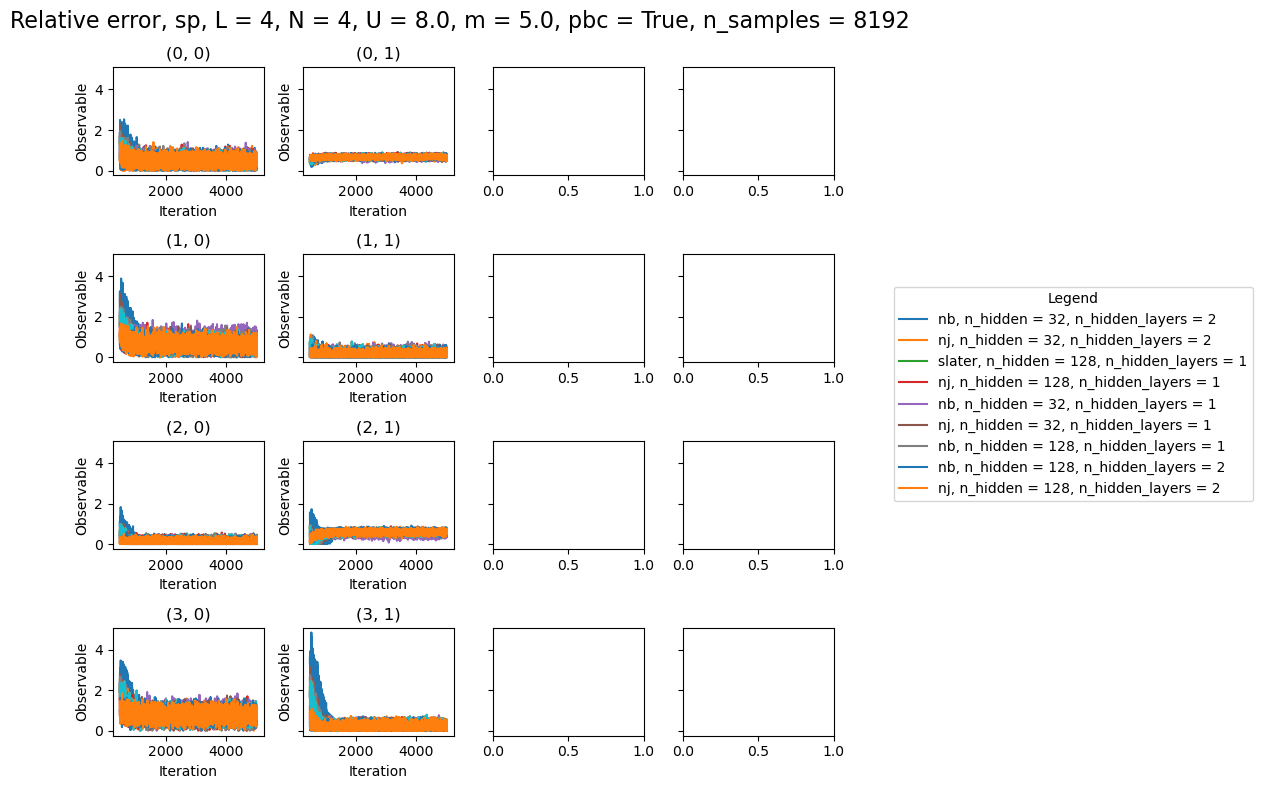

In [20]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

lines = []
labels = []

for data in data_to_plot:
    for i in range(n_corrs):
        x = i // L2
        y = i % L2
        #corr = f"nc{i}nc0"
        corrs_dmrg = (data_dmrg[0]['data']['corrs_results'][orbitals_dmrg])

        line, = axs[x][y].plot(x_values[start:end], 
                               np.abs((data["data"][orbitals_nk][i]['Mean']['real']- corrs_dmrg[x][y])/corrs_dmrg[x][y])[start:end], 
                               label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")


        #axs[x][y].axhline(y=corrs_dmrg[x][y], color='r', linestyle='--', label='DMRG') 
        
        axs[x][y].set_title(f"({x}, {y})")
        axs[x][y].set_xlabel('Iteration')
        axs[x][y].set_ylabel('Observable')

        # Collect lines and labels for the legend
        if line.get_label() not in labels:
            lines.append(line)
            labels.append(line.get_label())

title = f"Relative error, {orbitals_nk}, L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, n_samples = {n_samples}"
fig.suptitle(title, fontsize=16)

# Add a shared legend to the right of the figure
fig.legend(
    lines, labels, 
    loc='center right', 
    title="Legend", 
    bbox_to_anchor=(1.5, 0.5)
)

# Show the plot
plt.tight_layout()
plt.show()